## Script to compare sample clustering and correlation based on metallomics and proteomics 

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr, spearmanr

In [2]:

# Define the directory where the CSV files are located
input_dir_prot = '/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTproteomics/output/tables/completematrix/allmetals/allsamples'

# Define the filenames for the dataframes
filenames = [
    'proteome_pearson_corr.csv',
    'proteome_spearman_corr.csv',
    'proteome_euclidean_dist.csv',
    'proteome_manhattan_dist.csv'
]

# Create an empty list to store the dataframes
proteome_dataframes = []

# Read each dataframe and append it to the list
for filename in filenames:
    df = pd.read_csv(os.path.join(input_dir_prot, filename), index_col=0)
    proteome_dataframes.append(df)


In [16]:
proteome_dataframes

[               Ca 0   Ca 0.01   Ca 0.02   Ca 0.05    Ca 0.1    Ca 0.2  \
 BioSpecID                                                               
 Ca 0       1.000000  0.867337  0.816250  0.778724  0.648604  0.459950   
 Ca 0.01    0.867337  1.000000  0.806404  0.776732  0.662178  0.461796   
 Ca 0.02    0.816250  0.806404  1.000000  0.793653  0.673362  0.501480   
 Ca 0.05    0.778724  0.776732  0.793653  1.000000  0.670842  0.530596   
 Ca 0.1     0.648604  0.662178  0.673362  0.670842  1.000000  0.486265   
 ...             ...       ...       ...       ...       ...       ...   
 Zn 100     0.495628  0.477839  0.500815  0.487816  0.395612  0.331731   
 Zn 2       0.376069  0.332787  0.442961  0.442440  0.338962  0.407884   
 Zn 20      0.596460  0.564265  0.595409  0.625456  0.446494  0.428652   
 Zn 5       0.582256  0.501056  0.555362  0.566594  0.427749  0.404833   
 Zn 50      0.590784  0.568907  0.590791  0.596849  0.460605  0.428432   
 
              Ca 0.5      Ca 2      

In [23]:
# Melt the dataframe to convert it from wide format to long format
melted_df = proteome_dataframes[1].reset_index().melt(id_vars='BioSpecID', var_name='Column', value_name='Value')

# Filter out rows with NA values
non_na_combinations = melted_df.dropna()

# Count the number of non-NA combinations
num_non_na_combinations = non_na_combinations.shape[0]

# Display the result
print(f"Number of non-NA combinations: {num_non_na_combinations}")

melted_df['BioSpecID'].unique()

Number of non-NA combinations: 7744


array(['Ca 0', 'Ca 0.01', 'Ca 0.02', 'Ca 0.05', 'Ca 0.1', 'Ca 0.2',
       'Ca 0.5', 'Ca 2', 'Ca 5', 'Cu 0', 'Cu 0.01', 'Cu 0.02', 'Cu 0.05',
       'Cu 0.1', 'Cu 0.2', 'Cu 0.5', 'Cu 10', 'Cu 2', 'Cu 20', 'Cu 5',
       'Fe 0', 'Fe 0.01', 'Fe 0.02', 'Fe 0.05', 'Fe 0.2', 'Fe 0.5',
       'Fe 10', 'Fe 2', 'Fe 20', 'Fe 5', 'Fe 50', 'K 0.1', 'K 0.2',
       'K 0.5', 'K 2', 'K 5', 'Mg 0.05', 'Mg 0.1', 'Mg 0.2', 'Mg 0.5',
       'Mg 10', 'Mg 2', 'Mg 5', 'Mn 0', 'Mn 0.01', 'Mn 0.02', 'Mn 0.05',
       'Mn 0.1', 'Mn 0.2', 'Mn 0.5', 'Mn 10', 'Mn 100', 'Mn 2', 'Mn 20',
       'Mn 5', 'Mn 50', 'Mo 0', 'Mo 0.01', 'Mo 0.02', 'Mo 0.05', 'Mo 0.1',
       'Mo 0.2', 'Mo 0.5', 'Na 0', 'Na 0.01', 'Na 0.02', 'Na 0.05',
       'Na 0.1', 'Na 0.2', 'Na 0.5', 'Na 10', 'Na 100', 'Na 2', 'Na 20',
       'Na 5', 'Na 50', 'Zn 0.01', 'Zn 0.02', 'Zn 0.05', 'Zn 0.1',
       'Zn 0.2', 'Zn 0.5', 'Zn 10', 'Zn 100', 'Zn 2', 'Zn 20', 'Zn 5',
       'Zn 50'], dtype=object)

In [3]:

# Define the directory where the CSV files are located
input_dir_metal = '/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTmetallomics/output/tables'

# Define the filenames for the dataframes
filenames = [
    'metallome_pearson_corr.csv',
    'metallome_spearman_corr.csv',
    'metallome_euclidean_dist.csv',
    'metallome_manhattan_dist.csv'
]

# Create an empty list to store the dataframes
metallome_dataframes = []

# Read each dataframe and append it to the list
for filename in filenames:
    df = pd.read_csv(os.path.join(input_dir_metal, filename), index_col=0)
    metallome_dataframes.append(df)
    
    

In [4]:
def calculate_correlation_and_plot(prdf, mtdf):
    # Create an empty list to store individual DataFrames
    dfs_proteome = []

    # Loop through the columns of the original dataframe
    for column_name in prdf.columns:
        # Extract the rowname
        rowname = column_name

        # Create a DataFrame for the current column
        current_df = pd.DataFrame({
            'rowname': [rowname] * len(prdf),
            'column name': prdf.index,
            'proteome coefficient': prdf[column_name].values,
        })

        # Create a sorted unique combination of rowname and column name
        current_df['unique comb'] = current_df.apply(lambda x: '-'.join(sorted([x['rowname'], x['column name']])), axis=1)

        # Append the current DataFrame to the list
        dfs_proteome.append(current_df)

    # Concatenate all the DataFrames into one
    reshaped_proteome_df = pd.concat(dfs_proteome, ignore_index=True)
    reshaped_proteome_df = reshaped_proteome_df.drop_duplicates(subset='unique comb')

    # Create an empty list to store individual DataFrames
    dfs_metallome = []

    # Loop through the columns of the original dataframe
    for column_name in mtdf.columns:
        # Extract the rowname
        rowname = column_name

        # Create a DataFrame for the current column
        current_df = pd.DataFrame({
            'rowname': [rowname] * len(mtdf),
            'column name': mtdf.index,
            'metallome coefficient': mtdf[column_name].values,
        })

        # Create a sorted unique combination of rowname and column name
        current_df['unique comb'] = current_df.apply(lambda x: '-'.join(sorted([x['rowname'], x['column name']])), axis=1)

        # Append the current DataFrame to the list
        dfs_metallome.append(current_df)

    # Concatenate all the DataFrames into one
    reshaped_metallome_df = pd.concat(dfs_metallome, ignore_index=True)
    reshaped_metallome_df = reshaped_metallome_df.drop_duplicates(subset='unique comb')

    # Merge the two dataframes using the unique_comb column
    proteome_metallome_df = reshaped_proteome_df.merge(reshaped_metallome_df, on='unique comb')

    # Remove rows with NaNs
    proteome_metallome_df_cleaned = proteome_metallome_df.dropna(subset=['proteome coefficient', 'metallome coefficient'])

    # Calculate Pearson correlation and p-value
    pearson_corr, pearson_p_value = pearsonr(proteome_metallome_df_cleaned['proteome coefficient'], proteome_metallome_df_cleaned['metallome coefficient'])

    # Calculate Spearman correlation and p-value
    spearman_corr, spearman_p_value = spearmanr(proteome_metallome_df_cleaned['proteome coefficient'], proteome_metallome_df_cleaned['metallome coefficient'])
    
    # Flatten the proteome and metallome coefficients
    proteome_coefficient_flat = proteome_metallome_df_cleaned['proteome coefficient'].values.flatten()
    metallome_coefficient_flat = proteome_metallome_df_cleaned['metallome coefficient'].values.flatten()

    # Calculate the RV coefficient
    rv_coefficient = np.log(np.sum(proteome_coefficient_flat * metallome_coefficient_flat))

    print(f'Pearson Correlation: {pearson_corr:.2f}, P-Value: {pearson_p_value:.4f}')
    print(f'Spearman Correlation: {spearman_corr:.2f}, P-Value: {spearman_p_value:.4f}')
    print(f'RV Coefficient: {rv_coefficient:.2f}')
    
    proteome_metallome_df_cleaned['difference'] = proteome_metallome_df_cleaned['proteome coefficient'] - proteome_metallome_df_cleaned['metallome coefficient']

   # Create a colormap using 'coolwarm' or another colormap of your choice
    cmap = plt.get_cmap('coolwarm')

    # Scatter plot with points colored by the difference column using the colormap
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(data=proteome_metallome_df_cleaned, x='proteome coefficient', y='metallome coefficient', hue='difference', palette=cmap)
    plt.title(f'Pearson Correlation: {pearson_corr:.2f}, Spearman Correlation: {spearman_corr:.2f}')
    plt.xlabel('Proteome Coefficient')
    plt.ylabel('Metallome Coefficient')

    plt.show()

Pearson Correlation: 0.22, P-Value: 0.0000
Spearman Correlation: 0.16, P-Value: 0.0000
RV Coefficient: 5.01


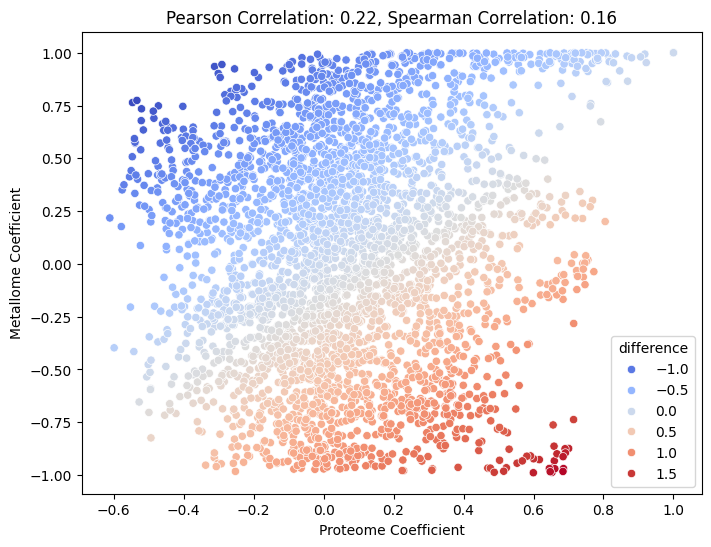

Pearson Correlation: 0.24, P-Value: 0.0000
Spearman Correlation: 0.18, P-Value: 0.0000
RV Coefficient: 5.14


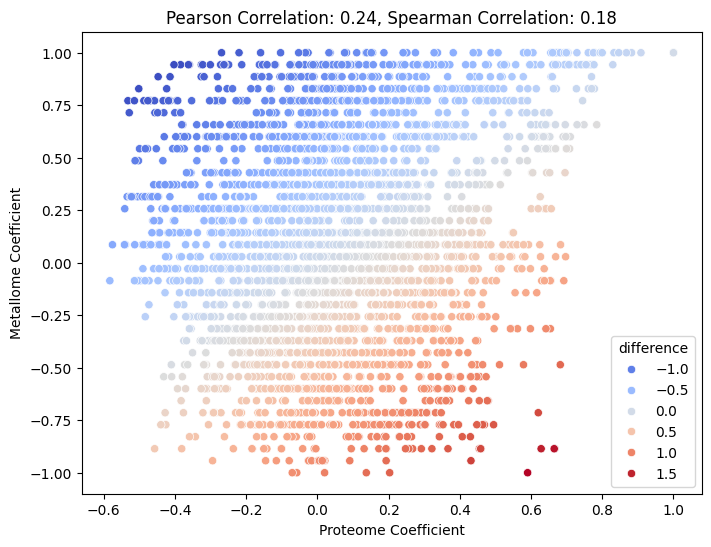

Pearson Correlation: -0.21, P-Value: 0.0000
Spearman Correlation: -0.18, P-Value: 0.0000
RV Coefficient: 4.98


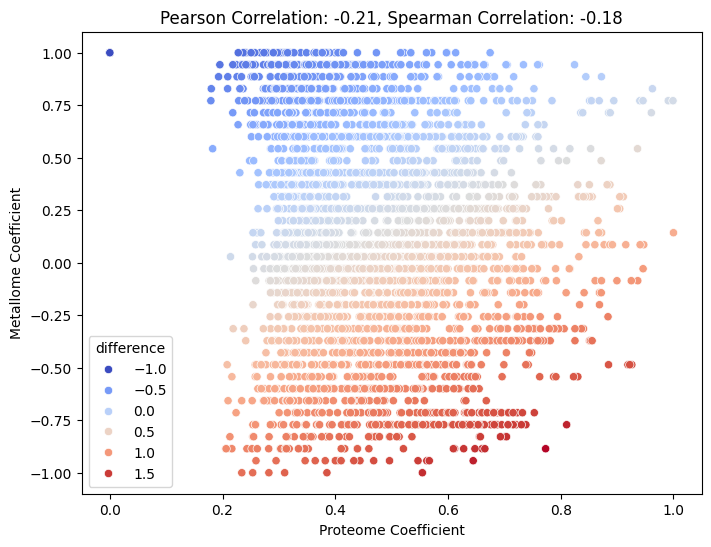

Pearson Correlation: 0.24, P-Value: 0.0000
Spearman Correlation: 0.36, P-Value: 0.0000
RV Coefficient: 8.02


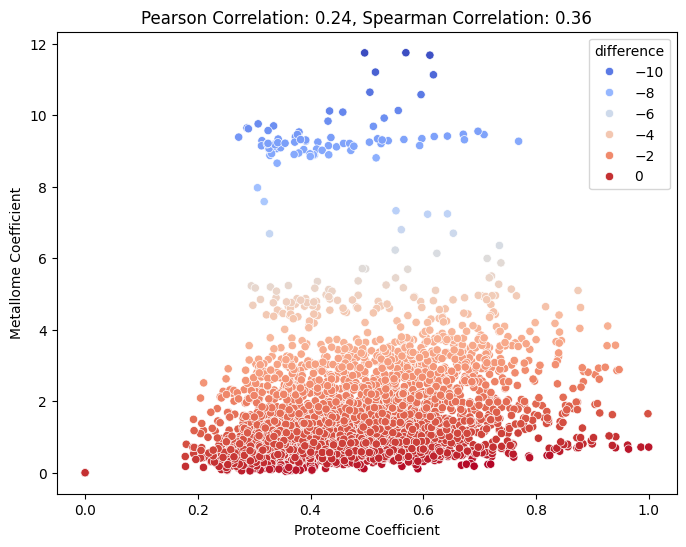

In [5]:

# Loop through corresponding datasets
for prdf, mtdf in zip(proteome_dataframes, metallome_dataframes):
    calculate_correlation_and_plot(prdf, mtdf)

In [6]:
sp_corr_prot = proteome_dataframes[1]

# Extract the upper triangle (excluding the diagonal) of the DataFrame
upper_triangle = np.triu(sp_corr_prot.values, k=1)

# Create a DataFrame from the upper triangle
upper_triangle_df = pd.DataFrame(upper_triangle, columns=sp_corr_prot.columns, index=sp_corr_prot.index)

# Stack the DataFrame to convert it to long format
stacked_df = upper_triangle_df.stack()

# Reset the index to have BioSpecID as rownames and colnames as columns
result_df = stacked_df.reset_index()

# Rename the columns
result_df.columns = ['BioSpecID', 'colname', 'coefficient']

# Separate BioSpecIDs into metal and conc
result_df[['metal1', 'conc1']] = result_df['BioSpecID'].str.split(' ', expand=True)
result_df[['metal2', 'conc2']] = result_df['colname'].str.split(' ', expand=True)

# Filter rows where metal1 is not equal to metal2
result_df = result_df[result_df['metal1'] != result_df['metal2']]

result_df.reset_index(drop=True, inplace=True)


In [7]:

result_df = result_df[result_df['coefficient'] != 0]
result_df

,BioSpecID,colname,coefficient,metal1,conc1,metal2,conc2
0,Ca 0,Cu 0,0.531854,Ca,0,Cu,0
1,Ca 0,Cu 0.01,0.453215,Ca,0,Cu,0.01
2,Ca 0,Cu 0.02,0.305133,Ca,0,Cu,0.02
3,Ca 0,Cu 0.05,0.434704,Ca,0,Cu,0.05
4,Ca 0,Cu 0.1,0.142668,Ca,0,Cu,0.1
...,...,...,...,...,...,...,...
5899,Na 50,Zn 100,0.291523,Na,50,Zn,100
5900,Na 50,Zn 2,0.395557,Na,50,Zn,2
5901,Na 50,Zn 20,0.295521,Na,50,Zn,20
5902,Na 50,Zn 5,0.253807,Na,50,Zn,5


In [8]:
## read in metal-metal metallomics correlations
metp_metm_df = pd.read_csv('/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTmetallomics/output/tables/metalperturbed_metalmeasured_correlations.csv')


,metal_measured,metal_perturbed,pearson,p_value_pearson,spearman,p_value_spearman,significant_pearson,significant_spearman
0,Ca,Fe,0.778003,4.191839e-07,0.928577,1.417303e-13,False,True
1,Ca,Mn,-0.150006,4.645227e-01,-0.015076,9.417286e-01,False,False
2,Ca,Na,-0.594685,2.763994e-03,-0.607560,2.105720e-03,False,False
3,Ca,Cu,0.720041,2.315845e-06,0.826238,3.185280e-09,False,True
4,Ca,Zn,-0.525304,4.098789e-03,-0.838510,2.537289e-08,False,True
5,Ca,Ca,0.917356,4.371799e-11,0.994343,6.890362e-25,True,True
6,Ca,Mo,0.943399,4.431321e-09,0.674617,2.133193e-03,True,False
7,Ca,Mg,-0.854410,1.642626e-03,-0.990867,3.010166e-08,True,True
8,Ca,K,-0.218936,5.177688e-01,0.179322,5.977898e-01,False,False
9,Fe,Cu,-0.712359,3.318753e-06,-0.587726,3.226638e-04,False,False


In [9]:

metp_metm_df_protcorr_df = pd.merge(result_df[['metal1',
                                              'metal2',
                                              'coefficient']], metp_metm_df[['metal_perturbed',
                                                             'metal_measured',
                                                             'spearman']], left_on=['metal1', 'metal2'],
                                    right_on=['metal_perturbed', 'metal_measured'], 
                                    how='inner')
metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.rename(columns={
    'coefficient': 'proteome coefficient',
    'spearman': 'metalperturbed_metalmeasured_sp_coeff'
})
metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.drop(columns=['metal1', 'metal2'])

metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.drop_duplicates()

In [10]:
metp_metm_df_protcorr_df

,proteome coefficient,metal_perturbed,metal_measured,metalperturbed_metalmeasured_sp_coeff
0,0.310395,Ca,Fe,0.184634
1,0.467097,Ca,Fe,0.184634
2,0.400796,Ca,Fe,0.184634
3,0.082762,Ca,Fe,0.184634
4,0.153201,Ca,Fe,0.184634
...,...,...,...,...
2756,0.291523,Na,Zn,0.151517
2757,0.395557,Na,Zn,0.151517
2758,0.295521,Na,Zn,0.151517
2759,0.253807,Na,Zn,0.151517


SyntaxError: unmatched ')' (1394201231.py, line 1)

In [ ]:
# Define a dictionary that maps elements to colors
element_color_mapping = {
    'Ca': "#A6CEE3",
    'Cu': "#33A02C",
    'Fe': "#E31A1C",
    'K': "#838B83",
    'Mg': "#FF7F00",
    'Mn': "#6A3D9A",
    'Mo': "#00868B",
    'Na': "#DAA520",
    'Zn': "#000080"
}

# Apply the color mapping to the 'element_perturbed' column
metp_metm_df_protcorr_df['color'] = metp_metm_df_protcorr_df['element_perturbed'].map(element_color_mapping)

# Create the scatter plot with custom colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    metp_metm_df_protcorr_df['metalperturbed_metalmeasured_sp_coeff'],
    metp_metm_df_protcorr_df['proteome coefficient'],
    c=metp_metm_df_protcorr_df['color'],  # Use the 'color' column for colors
    alpha=0.5
)

plt.xlabel('Metalperturbed_Metalmeasured_SP_Coeff')
plt.ylabel('Proteome Coefficient')
plt.title('Scatter Plot of Metalperturbed_Metalmeasured_SP_Coeff vs. Proteome Coefficient')
plt.grid(True)

# Add a legend for element colors
for element, color in element_color_mapping.items():
    plt.scatter([], [], c=color, label=element)

# Show the legend
plt.legend(loc='upper right', title='Element Perturbed')

plt.show()


In [ ]:

# Take the absolute values of the 'metalperturbed_metalmeasured_sp_coeff' and 'proteome coefficient' columns
metp_metm_df_protcorr_df['abs_metalperturbed_metalmeasured_sp_coeff'] = np.abs(metp_metm_df_protcorr_df['metalperturbed_metalmeasured_sp_coeff'])
metp_metm_df_protcorr_df['abs_proteome_coefficient'] = np.abs(metp_metm_df_protcorr_df['proteome coefficient'])

# Create the scatter plot with absolute values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    metp_metm_df_protcorr_df['abs_metalperturbed_metalmeasured_sp_coeff'],
    metp_metm_df_protcorr_df['abs_proteome_coefficient'],
    c=metp_metm_df_protcorr_df['color'],  # Use the 'color' column for colors
    alpha=0.5
)

plt.xlabel('Absolute Metalperturbed_Metalmeasured_SP_Coeff')
plt.ylabel('Absolute Proteome Coefficient')
plt.title('Scatter Plot of Absolute Metalperturbed_Metalmeasured_SP_Coeff vs. Absolute Proteome Coefficient')
plt.grid(True)

# Add a legend for element colors
for element, color in element_color_mapping.items():
    plt.scatter([], [], c=color, label=element)

# Show the legend
plt.legend(loc='upper right', title='Element Perturbed')

plt.show()
